# This file aims to illustrate the comparison of the measured channel property and the simulated channel property extracted from the three layer hierarchical Markov model. $M=N=128$

![](Channel_property.assets\Snipaste_2021-12-06_09-49-15.png)

M. K. Samimi and T. S. Rappaport, "3-D Millimeter-Wave Statistical Channel Model for 5G Wireless System Design," in IEEE Transactions on Microwave Theory and Techniques, vol. 64, no. 7, pp. 2207-2225, July 2016, doi: 10.1109/TMTT.2016.2574851.

## What is `lobes`
Lobes is '`spatial lobes (SLs)`' corresponse to '`Time Clusters (TCs)`'
|  SLs   | TCs  |
|  ----  | ----  |
| ![SLs](Channel_property.assets\SpatialLobes.png)  | ![TCs](Channel_property.assets\TimeClusters.png) |





## what is $\mu_M,\ \mu_S, \sigma_M, \sigma_S$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import scipy.io as sio 

0.16666666666666666


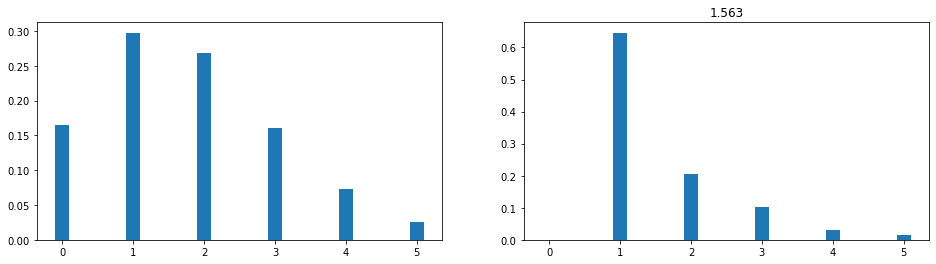

In [2]:
np.random.seed(0)
# measured = np.random.poisson(1.8, size=64)
x = np.array([0, 1,2,3,4,5])
measured_sampl = poisson.rvs(1.3, size = 1000)
for i, m in enumerate(measured_sampl):
    if m == 0:
        measured_sampl[i] = 1
    if m > 5:
        measured_sampl[i] = 5


# print(measured_sampl)
measured = poisson.pmf(x, 1.8)

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.bar(x, measured , width=0.2)
plt.subplot(1,2,2)
data_measured, bins, patches = plt.hist(measured_sampl, rwidth=0.2, density= True, bins = np.array([0, 1,2,3,4,5,6])-0.5)
plt.title(str(measured_sampl.mean()))
print(data_measured.mean())


In [3]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.special import gamma as gamma_function
from scipy.special import digamma
alpha_0, alpha_1 = 1, 1
beta_0, beta_1 = 0.001, 1
K=4
p01 = 0.5
p10 = 0.5
trans_pro_C = {
    'p01':p01,
    'p10':p10,
    'p1':p01/(p01+p10)
    }
M = 64
tau = 8
L = 4

## generate channel support
def count_lobes_return_array(p01 = 0.5, p10 = 0.5, M = 64):
    count_list = np.array([0 for i in range(6)])
    # 6 is a nice value
    def count_lobes(seed = 2, p01 = 0.5, p10 = 0.5, M = 64):
        np.random.seed(seed)   
        def common_channel_support(p01 = 0.1, p10=0.3, M= 64):
            p0 = p10/(p10+p01)
            p1 = 1-p0

            # generate Markov chain
            tmp_support = np.array([0.0 for m in range(M)])
            if np.random.uniform(0,1,1)[0] < p0:
                tmp_support[0] = 0
            for i in range(M - 1):
                if tmp_support[i] == 0:
                    if np.random.uniform(0,1,2)[0] < p01:
                        tmp_support[i+1] = 1
                    else:
                        tmp_support[i+1] = 0
                else:
                    if np.random.uniform(0,1,2)[1] < p10:
                        tmp_support[i+1] = 0
                    else:
                        tmp_support[i+1] = 1
            return tmp_support

        common_support_varphi = common_channel_support(p01, p10, M)

        marker_left = 0
        marker_rigth = 1
        state_store_deep_1 = ''
        state = '' # 'up_edge' | 'up_idle' | 'down_idle' | 'down_edge'
        while marker_rigth != M:
            state_store_deep_1 = state
            if common_support_varphi[marker_rigth] ==1 and common_support_varphi[marker_rigth -1] ==0:
                state = 'up_edge'
                marker_left = marker_rigth - 1
            
            elif common_support_varphi[marker_rigth] ==0 and common_support_varphi[marker_rigth -1] ==1:
                state = 'down_edge'
            elif common_support_varphi[marker_rigth] ==1 and common_support_varphi[marker_rigth -1] ==1:
                state = state_store_deep_1
            elif common_support_varphi[marker_rigth] ==0 and common_support_varphi[marker_rigth -1] ==0:
                state = state_store_deep_1
            if state_store_deep_1 == 'up_edge' and state == 'down_edge':
                # print(marker_rigth, marker_rigth - marker_left -1 )
                wdith = marker_rigth - marker_left -1
                if wdith > 5:
                    count_list[5] += 0
                else:
                    count_list[wdith] += 1

            marker_rigth +=1

    for seed in range(10):
        count_lobes(
            seed = seed,
            p10 = p10,
            p01 = p01,
            M = 64
            )
    return np.array(count_list/count_list.sum())


def calculate_NMSE(mat_True, mat_Est):
    vector_True = np.reshape(np.array(mat_True), (1,-1))[0]
    vector_Est = np.reshape(np.array(mat_Est), (1,-1))[0]
    # Numerator and denominator
    NMSE_numerator = 0
    NMSE_denominator = 0 
    for index, value_true in enumerate(vector_True):
        value_Est = vector_Est[index]
        NMSE_numerator += np.power(np.abs(value_Est - value_true), 2)
        NMSE_denominator += np.power(np.abs(value_true), 2)
    return NMSE_numerator / NMSE_denominator

def compare_s_m():
    min_NMSE = np.inf
    N_para = 100
    x_para = np.linspace(0,1,N_para)

    result = {
        'min_NMSE':-1,
        'p01' : -1,
        'p10' : -1,
        }
    for n_r in range(N_para):
        for n_c in range(N_para):
            data_sim = count_lobes_return_array(
                p01= x_para[n_r],
                p10 = x_para[n_c], 
                M= 64
            )
            NMSE_para = calculate_NMSE(data_measured, data_sim)
            if NMSE_para < min_NMSE:
                result['min_NMSE'] = NMSE_para
                result['p01'] = x_para[n_r]
                result['p10'] = x_para[n_c]
                min_NMSE = NMSE_para
    return result

result_para = compare_s_m()
data_sim = count_lobes_return_array(
    p01= result_para['p01'],
    p10 = result_para['p10'], 
    M= 64
)

data_measured = np.array(data_measured)
plt.figure(figsize=(8,4), dpi=300)
plt.grid()
plt.bar(np.array(range(6))-0.1, data_measured, width= 0.2)
plt.bar(np.array(range(6))+0.1, data_sim, width= 0.2)
print(np.array(data_measured))
print(np.array(data_sim))
# measured_sampl
data_sim = np.array(data_sim)
mu_s = np.sum(data_sim * np.array(range(len(data_sim))))
mu_m = np.sum(data_measured * np.array(range(len(data_measured))))
sigma_s = np.power(
    np.sum(np.power(data_sim, 2) * np.power(np.array(range(6)) - mu_s, 2)) / np.sum(np.power(data_sim, 2)),
    0.5)
sigma_m = np.power(
    np.sum(np.power(data_measured, 2) * np.power(np.array(range(6)) - mu_m, 2)) / np.sum(np.power(data_measured, 2)),
    0.5)
print("mu_s = "+ str(mu_s))
print("mu_m = "+ str(mu_m))
print("sigma_s = "+ str(sigma_s))
print("sigma_m = "+ str(sigma_m))
plt.legend(
    [r'measured $\mu_M = 1.56, \sigma_M = 0.60$', r'simulated $\mu_S = 1.55, \sigma_S = 0.58$']
    )

# plt.scatter(range(M), common_support_varphi)
# plt.plot(range(M), common_support_varphi)
# plt.legend(['common_support_varphi'])

# data_sim = np.array(count_list/count_list.sum())
sio.savemat(
    'NumberOfLobes_NLoS.mat', {
        'NumberOfLobes_NLoS':{
        'Sim_x': [i for i in range(6)], 
        'Sim_y': data_sim, 
        'Sim_Mu':1.55, 
        'Sim_Sigma': 0.58,
        'Mea_x': [i for i in range(6)], 
        'Mea_y': data_measured, 
        'Mea_Mu': 1.56, 
        'Mea_Sigma': 0.60,
        'p01': result_para['p01'],
        'p01': result_para['p10'],
        }
    }
    
)

C:\Users\BROOK1~1\AppData\Local\Temp/ipykernel_22016/912796246.py:28: RuntimeWarning: invalid value encountered in double_scalars
  p0 = p10/(p10+p01)
C:\Users\BROOK1~1\AppData\Local\Temp/ipykernel_22016/912796246.py:83: RuntimeWarning: invalid value encountered in true_divide
  return np.array(count_list/count_list.sum())


# Gaussian Parameters

![](Channel_property.assets\Parameters.png)

choose NLOS $\sigma_{\theta, AOA} = 10.1 (deg) $

# What is angular spread?

Angular Spread Measurement and Modeling for 3D
MIMO in Urban Macrocellular Radio Channels
$$
\operatorname{ESA}=\sqrt{\frac{\sum_{k=1}^{K}\left(\vartheta_{k}-\mu_{A P S}\right)^{2} \alpha_{k}^{2}}{\sum_{k=1}^{K} \alpha_{k}^{2}}},
$$

$$
\mu_{A P S}=\frac{\sum_{k=1}^{K} \vartheta_{k} \alpha_{k}^{2}}{\sum_{k=1}^{K} \alpha_{k}^{2}}
$$

In [ ]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.special import gamma as gamma_function
from scipy.special import digamma
alpha_0, alpha_1 = 1, 1
beta_0, beta_1 = 0.001, 1
K=4
p01 = 0.5
p10 = 0.5
trans_pro_C = {
    'p01':p01,
    'p10':p10,
    'p1':p01/(p01+p10)
    }
M = 64
tau = 8
L = 4

In [ ]:
def gen_common_channel_support(seed = 2):
    np.random.seed(seed)
    def common_channel_support(p01 = 0.1, p10=0.3, M= 64):
        p0 = p10/(p10+p01)
        p1 = 1-p0

        # generate Markov chain
        tmp_support = np.array([0.0 for m in range(M)])
        if np.random.uniform(0,1,1)[0] < p0:
            tmp_support[0] = 0
        for i in range(M - 1):
            if tmp_support[i] == 0:
                if np.random.uniform(0,1,2)[0] < p01:
                    tmp_support[i+1] = 1
                else:
                    tmp_support[i+1] = 0
            else:
                if np.random.uniform(0,1,2)[1] < p10:
                    tmp_support[i+1] = 0
                else:
                    tmp_support[i+1] = 1
        return tmp_support

    common_support_varphi = common_channel_support(p01, p10, M)
    
    common_support_varphi = np.array(common_support_varphi)
    
    # common_support_varphi[int(M/4):] = 0
    r = gamma.rvs(2, 0, 1, size = M)

    Beta_true = np.random.normal(0, np.power(r, -1), M)
    # Beta_true = np.random.normal(0,1, M)

    Delta_varphi_min = 0
    Delta_varphi_max = 1/M
    Delta_varphi = np.random.uniform(Delta_varphi_min, Delta_varphi_max, M)
    Varphi_grid = np.array([m/M if m/M < 0.5 else m/M - 1 for m in range(M)])
    Varphi_true = common_support_varphi * (Delta_varphi + Varphi_grid)
    return Varphi_true, Beta_true

(0.0, 130.0)

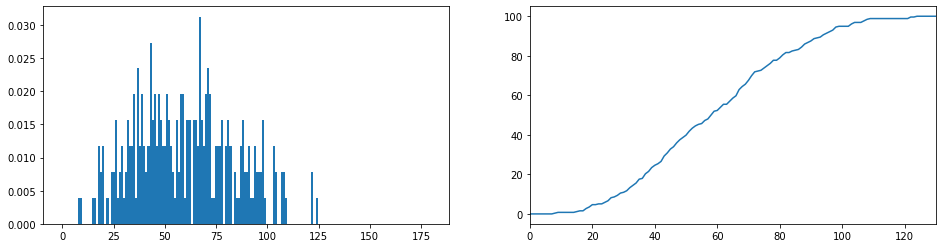

In [ ]:
cum_list = []
for i in range(256):
    Varphi_true, Beta_true = gen_common_channel_support(
        seed = i,
        )
    Beta_true = Beta_true
    # plt.plot(np.array(range(M)),Varphi_true)
    # plt.plot(np.array(range(M)),Beta_true)
    mu_APS_rad = np.sum(Varphi_true * np.power(Beta_true,2)) / np.sum(np.power(Beta_true,2))
    ESA_rad = np.power(
        np.sum(np.power(Varphi_true - mu_APS_rad, 2) * np.power(Beta_true, 2)) / np.sum(np.power(Beta_true, 2)),
        0.5
        ) *2* np.pi 
    cum_list.append(ESA_rad)
# print(mu_APS_rad * 180 / np.pi)
# print(ESA_rad * 180 / np.pi)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
pdf, bins, patches = plt.hist(np.array(cum_list) * 180 / np.pi, bins = [-0.5+i for i in range(180 + 1)], density=True)
cdf = np.cumsum(pdf) * 100
plt.subplot(1,2,2)
plt.plot([i for i in range(180)], cdf)
plt.xlim(left=0, right=130)


In [ ]:
measured_cdf_x = np.array([26, 83, 87, 121, 131, 133 ,139, 169, 175, 188, 218, 302,314, 382,406,418,426,522,554,604]) / 160 *20
measured_cdf_y = np.array([43,91,139,186,233,278,326,372,420,468,513,560,607,656,703,745,795,842,889,935]) / 92 *10

59.6420576956273
33.7375


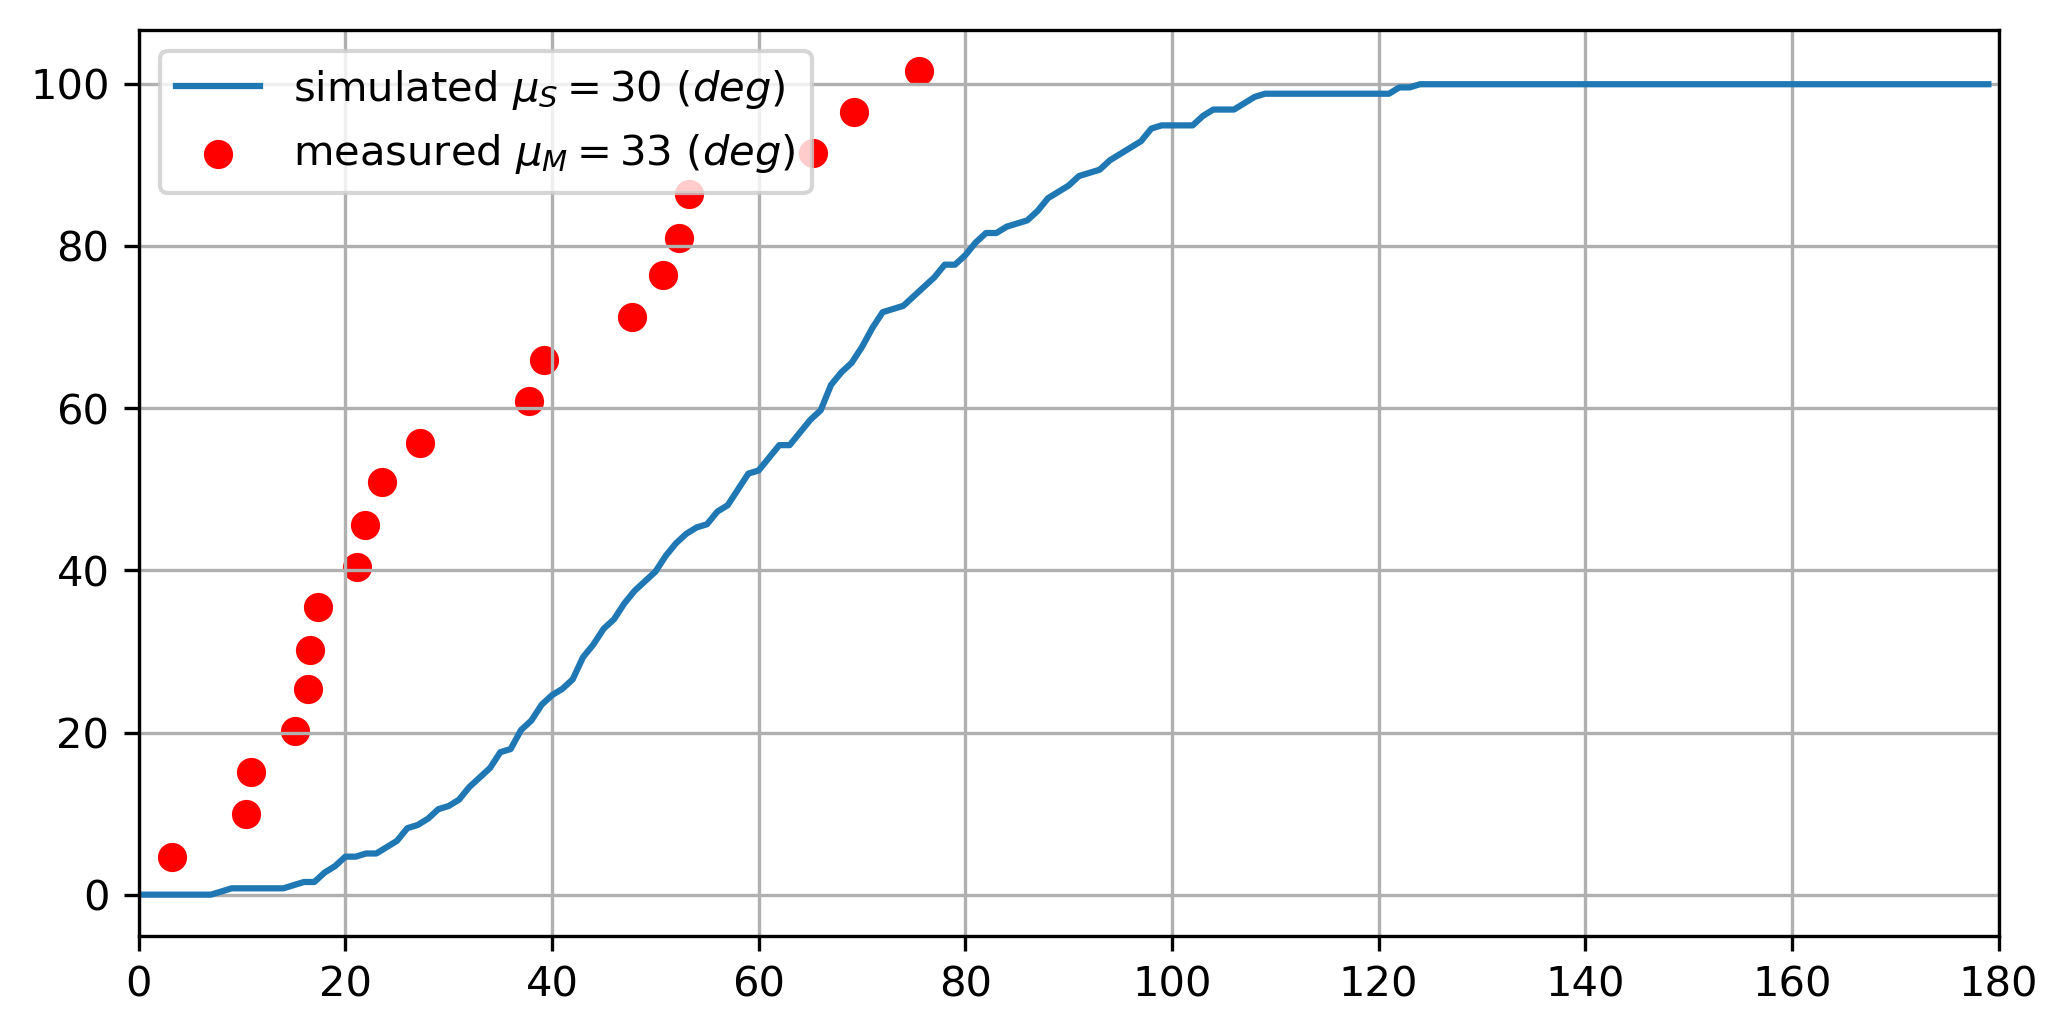

In [ ]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot([i for i in range(180)], cdf)
plt.scatter(measured_cdf_x, measured_cdf_y, color='r')
plt.xlim(left=0, right=180)
plt.grid()
plt.legend(
    [r'simulated $\mu_S = 30\ (deg)$',
    r'measured $\mu_M = 33\ (deg)$']
    )
print(np.sum(np.array(cum_list) * 180 / np.pi)/ len(cum_list))
print(measured_cdf_x.sum()/ len(measured_cdf_x))
sio.savemat(
    'AngularSpread.mat', 
    {
        'Sim_x': [i for i in range(180)], 
        'Sim_y': cdf, 
        'Sim_Mu':30,
        'Mea_x': measured_cdf_x, 
        'Mea_y': measured_cdf_y, 
        'Mea_Mu': 33
    }
)
